<a href="https://colab.research.google.com/github/HussainBadreddeen/AutoML_Thesis/blob/main/H2o_thesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

from google.colab import drive
drive.mount('/content/drive')
# df_normalized_reviews.to_csv("/content/drive/My Drive/processed_data.csv", index=False, encoding="utf-8-sig") #fixed it utf-8 doesnt wokr although it did before
import pandas as pd
import numpy as np
#load it back
df_normalized_reviews2 = pd.read_csv("/content/drive/My Drive/processed_data.csv") #the nan row comes back somehow # update cleaned it and saved and doesnt come back now


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

print(df_normalized_reviews2[df_normalized_reviews2.isna().any(axis=1)])
empty_or_nan_values = df_normalized_reviews2[df_normalized_reviews2.isna().any(axis=1)]
empty_or_nan_values

df_normalized_reviews2 = df_normalized_reviews2[df_normalized_reviews2['stemmed_text'].notna()]  # remove rows where stemmed_text is NaN
print(df_normalized_reviews2[df_normalized_reviews2.isna().any(axis=1)])
empty_or_nan_values = df_normalized_reviews2[df_normalized_reviews2.isna().any(axis=1)]
empty_or_nan_values
#i saved the dataset again after here and now it doesnt need removing this line again so no need to run this cell anymore

Empty DataFrame
Columns: [rating, review, normalized_review, tokens, filtered_tokens, stemmed_text]
Index: []
Empty DataFrame
Columns: [rating, review, normalized_review, tokens, filtered_tokens, stemmed_text]
Index: []


,rating,review,normalized_review,tokens,filtered_tokens,stemmed_text


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer # this is good: https://www.youtube.com/watch?v=rcovF6S1oFI
tfidf_vectorizer = TfidfVectorizer(
     # max_features=10000,      # Limit to 10k features # update i will use just min and max and wont test chunking on all 71k unique words/features
    min_df=5,                # Remove rare words (appearing in less than 5 documents/rows)
    max_df=0.8,              # Remove overly common words (appearing in more than 80% of documents)
    dtype=np.float32          # Use float32 to save memory
)


# Fit and transform the stemmed text vocab
tfidf_matrix = tfidf_vectorizer.fit_transform(df_normalized_reviews2["stemmed_text"])

# Print the shape of the matrix
print("Shape of the TF-IDF matrix:", tfidf_matrix.shape)
#converting the sparse matrix to dense in case i need to use the dense matrix
# X_dense = tfidf_matrix.astype(np.float32).toarray()

# np.save('C:/Users/hussa/OneDrive/Desktop/thesis_code/tfidf_dense.npy', X_dense)


Shape of the TF-IDF matrix: (102961, 9819)


#update using 71k words seems unprofessional might overfit and introduce noise and computation problems as im having them already.

#will probably use min_df and max_df to limit words more and try dense matrix again on drive first then maybe local but will always opt for drive till exhaustion

#loading dense matrix and ratings from drive

In [ ]:
import numpy as np

# Load pre-saved files #the labels are already mapped and the dense matrix is already ready and is 3.7gb (9.8k words converted using float32 isntead of 64) insteado of 55gb with all words
# X = np.load('C:/Users/hussa/OneDrive/Desktop/thesis_code/tfidf_dense.npy', mmap_mode='r')  # efficient read
# y = np.load('C:/Users/hussa/OneDrive/Desktop/thesis_code/labels_binary.npy')

from google.colab import drive
drive.mount('/content/drive')
X = np.load('/content/drive/My Drive/tfidf_dense.npy', mmap_mode='r')  # efficient read for dense matrix but i wont use it cause ram never handles it so i use the sparse matrix
y = np.load('/content/drive/My Drive/labels_binary.npy')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# installing H2o dependencies

In [ ]:
!pip install h2o

# Intializing H2o container and setting test train split 80/20 and adjusting depenedent and independent variables

In [ ]:
import h2o
from h2o.automl import H2OAutoML
from h2o.estimators import H2OXGBoostEstimator
import numpy as np


h2o.init()

# Convert to H2OFrame
X_h2o = h2o.H2OFrame(tfidf_matrix)
y_h2o = h2o.H2OFrame(y.reshape(-1, 1), column_names=['rating']).asfactor()
# Combine features (X) and target (y) into a single H2OFrame
df_h2o = X_h2o.cbind(y_h2o)
# Specify the target column and features
target_column = 'rating'
feature_columns = df_h2o.columns
feature_columns.remove(target_column)

train, test = df_h2o.split_frame(ratios=[.8], seed=1)#seed =1 to ensure that the random operations (like the train-test split or cross-validation splits) produce the same results each time the code is run so we can reproduce same results


#if i dont specify include algo ="algo_name"
#h20 then tries these:
# GLM	Linear models (good for interpretability)
# GBM	H2O's own gradient boosting implementation
# XGBoost	Highly efficient tree-based model (enabled if system supports it — Colab does)
# DRF	Distributed Random Forest
# DeepLearning	Simple fully connected feed-forward neural net
# StackedEnsemble	Combines the best-performing models
# XRT	Variation of Random Forest with extra randomness (might not always show up depending on settings)

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,14 mins 48 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.7
H2O_cluster_version_age:,"21 days, 21 hours and 48 minutes"
H2O_cluster_name:,H2O_from_python_unknownUser_a7c96j
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.027 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


# Running H2o with all algorithims for 3 hours

In [ ]:
aml = H2OAutoML(max_models=10, seed=1, nfolds=5, max_runtime_secs=10800)
aml.train(x=feature_columns, y=target_column, training_frame=train)
# View the leaderboard (top-performing models)
lb = aml.leaderboard
print(lb)

# Predict on the test set
preds = aml.predict(test)

# Evaluate the predictions
print("\nSample Predictions:\n", preds.head())

# Get list of models from leaderboard
model_ids = list(aml.leaderboard['model_id'].as_data_frame().values.flatten())

# Inspect top model (best one)
top_model = h2o.get_model(model_ids[0])
print(f"\nBest model ID: {model_ids[0]}")
print("Algorithm used:", top_model.algo)

# Summary
try:
    print("\nModel Summary:")
    print(top_model.summary())
except:
    print("No summary available for this model.")

# Hyperparameters
print("\nHyperparameters:")
print(top_model.params)

# Variable importance (if supported)
try:
    print("\nVariable Importance:")
    print(top_model.varimp(use_pandas=True))
except:
    print("Variable importance not available for this model.")

# Evaluate on test set
perf = top_model.model_performance(test_data=test)
print("\nModel Performance on Test Set:")
print(perf)
print("\nConfusion Matrix:\n", perf.confusion_matrix())
print("\nAUC:", perf.auc())

model_path = h2o.save_model(model=top_model, path="/content/drive/My Drive/h2o_model", force=True)
print("Model saved to:", model_path)


AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
model_id                                 auc    logloss     aucpr    mean_per_class_error      rmse        mse
XGBoost_1_AutoML_1_20250418_135015  0.97507    0.196236  0.970262               0.0744532  0.237984  0.0566365
GLM_1_AutoML_1_20250418_135015      0.959024   0.257488  0.950583               0.0972575  0.272323  0.0741599
[2 rows x 7 columns]

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%

Sample Predictions:
   predict           p0        p1
        1  0.00121421   0.998786
        1  0.000745356  0.999255
        1  0.000979662  0.99902
        1  0.00142336   0.998577
        1  0.0021807    0.997819
        1  0.0200986    0.979901
        1  0.414866     0.585134
        1  0.00707048   0.99293
        1  0.00744319   0.992557
        1  0.202766     0.797234
[10 rows x 3 columns]



/usr/local/lib/python3.11/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"



Best model ID: XGBoost_1_AutoML_1_20250418_135015
Algorithm used: xgboost

Model Summary:
Model Summary: 
    number_of_trees
--  -----------------
    81

Hyperparameters:
{'model_id': {'default': None, 'actual': {'__meta': {'schema_version': 3, 'schema_name': 'ModelKeyV3', 'schema_type': 'Key<Model>'}, 'name': 'XGBoost_1_AutoML_1_20250418_135015', 'type': 'Key<Model>', 'URL': '/3/Models/XGBoost_1_AutoML_1_20250418_135015'}, 'input': None}, 'training_frame': {'default': None, 'actual': {'__meta': {'schema_version': 3, 'schema_name': 'FrameKeyV3', 'schema_type': 'Key<Frame>'}, 'name': 'AutoML_1_20250418_135015_training_py_6_sid_926e', 'type': 'Key<Frame>', 'URL': '/3/Frames/AutoML_1_20250418_135015_training_py_6_sid_926e'}, 'input': {'__meta': {'schema_version': 3, 'schema_name': 'FrameKeyV3', 'schema_type': 'Key<Frame>'}, 'name': 'AutoML_1_20250418_135015_training_py_6_sid_926e', 'type': 'Key<Frame>', 'URL': '/3/Frames/AutoML_1_20250418_135015_training_py_6_sid_926e'}}, 'validation_f

# Running H2o with Xgboost only for 3 hours

In [ ]:
aml_xgb = H2OAutoML(max_models=10, seed=1, nfolds=5, max_runtime_secs=10800, include_algos=["XGBoost"])
aml_xgb.train(x=feature_columns, y=target_column, training_frame=train)
# View the leaderboard (top-performing models)
lb = aml.leaderboard
print(lb)

# Predict on the test set
preds = aml.predict(test)

# Evaluate the predictions
print("\nSample Predictions:\n", preds.head())

# Get list of models from leaderboard
model_ids = list(aml.leaderboard['model_id'].as_data_frame().values.flatten())

# Inspect top model (best one)
top_model = h2o.get_model(model_ids[0])
print(f"\nBest model ID: {model_ids[0]}")
print("Algorithm used:", top_model.algo)

# Summary
try:
    print("\nModel Summary:")
    print(top_model.summary())
except:
    print("No summary available for this model.")

# Hyperparameters
print("\nHyperparameters:")
print(top_model.params)

# Variable importance (if supported)
try:
    print("\nVariable Importance:")
    print(top_model.varimp(use_pandas=True))
except:
    print("Variable importance not available for this model.")

# Evaluate on test set
perf = top_model.model_performance(test_data=test)
print("\nModel Performance on Test Set:")
print(perf)
print("\nConfusion Matrix:\n", perf.confusion_matrix())
print("\nAUC:", perf.auc())

model_path2 = h2o.save_model(model=top_model, path="/content/drive/My Drive/h2o_model_xgboost_only", force=True)
print("Model saved to:", model_path2)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
model_id                                 auc    logloss     aucpr    mean_per_class_error      rmse        mse
XGBoost_1_AutoML_1_20250418_135015  0.97507    0.196236  0.970262               0.0744532  0.237984  0.0566365
GLM_1_AutoML_1_20250418_135015      0.959024   0.257488  0.950583               0.0972575  0.272323  0.0741599
[2 rows x 7 columns]

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%

Sample Predictions:
   predict           p0        p1
        1  0.00121421   0.998786
        1  0.000745356  0.999255
        1  0.000979662  0.99902
        1  0.00142336   0.998577
        1  0.0021807    0.997819
        1  0.0200986    0.979901
        1  0.414866     0.585134
        1  0.00707048   0.99293
        1  0.00744319   0.992557
        1  0.202766     0.797234
[10 rows x 3 columns]



/usr/local/lib/python3.11/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"



Best model ID: XGBoost_1_AutoML_1_20250418_135015
Algorithm used: xgboost

Model Summary:
Model Summary: 
    number_of_trees
--  -----------------
    81

Hyperparameters:
{'model_id': {'default': None, 'actual': {'__meta': {'schema_version': 3, 'schema_name': 'ModelKeyV3', 'schema_type': 'Key<Model>'}, 'name': 'XGBoost_1_AutoML_1_20250418_135015', 'type': 'Key<Model>', 'URL': '/3/Models/XGBoost_1_AutoML_1_20250418_135015'}, 'input': None}, 'training_frame': {'default': None, 'actual': {'__meta': {'schema_version': 3, 'schema_name': 'FrameKeyV3', 'schema_type': 'Key<Frame>'}, 'name': 'AutoML_1_20250418_135015_training_py_6_sid_926e', 'type': 'Key<Frame>', 'URL': '/3/Frames/AutoML_1_20250418_135015_training_py_6_sid_926e'}, 'input': {'__meta': {'schema_version': 3, 'schema_name': 'FrameKeyV3', 'schema_type': 'Key<Frame>'}, 'name': 'AutoML_1_20250418_135015_training_py_6_sid_926e', 'type': 'Key<Frame>', 'URL': '/3/Frames/AutoML_1_20250418_135015_training_py_6_sid_926e'}}, 'validation_f

#default params xgboost

In [ ]:
# Train a default XGBoost model manually
xgb_default = H2OXGBoostEstimator(seed=1)  # default params
xgb_default.train(x=feature_columns, y=target_column, training_frame=train)

# Predict
preds = xgb_default.predict(test)

# Evaluate
print("\nSample Predictions:\n", preds.head())

perf = xgb_default.model_performance(test_data=test)
print("\nModel Performance on Test Set:")
print(perf)
print("\nConfusion Matrix:\n", perf.confusion_matrix())
print("\nAUC:", perf.auc())

# Variable importance (if supported)
try:
    print("\nVariable Importance:")
    print(xgb_default.varimp(use_pandas=True))
except:
    print("Variable importance not available for this model.")

# Save the model
model_path3 = h2o.save_model(model=xgb_default, path="/content/drive/My Drive/h2o_model_xgboost_only_Default", force=True)
print("Model saved to:", model_path3)


xgboost Model Build progress: |██████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%

Sample Predictions:
   predict           p0        p1
        1  0.0051617    0.994838
        1  0.0028429    0.997157
        1  0.00489235   0.995108
        1  0.00958383   0.990416
        1  0.000906229  0.999094
        1  0.049936     0.950064
        1  0.169328     0.830672
        1  0.00630349   0.993697
        1  0.00327194   0.996728
        1  0.375617     0.624383
[10 rows x 3 columns]


Model Performance on Test Set:
ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.06243290304707352
RMSE: 0.2498657700587928
LogLoss: 0.21391178506780664
Mean Per-Class Error: 0.08208029741851922
AUC: 0.9719187799142706
AUCPR: 0.9677642547563013
Gini: 0.9438375598285411

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4705261041720708
       0     1      Error    Rate
-----  

# comparing results using confusion matrix, AUC

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Create a dictionary of models to compare
models = {
    "AutoML (All Algorithms)": aml.leader,
    "AutoML (XGBoost Only)": aml_xgb.leader,
    "Manual XGBoost (Default)": xgb_default
}

# Convert test labels to numpy array for sklearn metrics
y_true = test[target_column].as_data_frame().values.flatten()

print("=== MODEL COMPARISON ===\n")

for model_name, model in models.items():
    print(f"\n--- {model_name} ---")

    # Predict on test set
    preds = model.predict(test)
    preds_df = preds.as_data_frame()

    # Convert predictions to numpy
    if 'predict' in preds_df.columns:
        y_pred = preds_df['predict'].values
    else:
        y_pred = preds_df.iloc[:, 0].values  # fallback

    # Print H2O confusion matrix and AUC
    perf = model.model_performance(test_data=test)
    print("H2O Confusion Matrix:\n", perf.confusion_matrix())
    print("AUC:", perf.auc())

    # Print scikit-learn metrics (for more detail)
    print("\nSklearn Classification Report:")
    print(classification_report(y_true, y_pred, digits=4))


/usr/local/lib/python3.11/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


=== MODEL COMPARISON ===


--- AutoML (All Algorithms) ---
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%


/usr/local/lib/python3.11/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


H2O Confusion Matrix:
 Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.414814523675225
       0     1      Error    Rate
-----  ----  -----  -------  ----------------
0      9247  1058   0.1027   (1058.0/10305.0)
1      505   9822   0.0489   (505.0/10327.0)
Total  9752  10880  0.0758   (1563.0/20632.0)
AUC: 0.9747044709329523

Sklearn Classification Report:
              precision    recall  f1-score   support

           0     0.9427    0.9033    0.9226     10305
           1     0.9074    0.9452    0.9259     10327

    accuracy                         0.9243     20632
   macro avg     0.9250    0.9243    0.9243     20632
weighted avg     0.9250    0.9243    0.9243     20632


--- AutoML (XGBoost Only) ---
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%


/usr/local/lib/python3.11/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


H2O Confusion Matrix:
 Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4406862386635372
       0     1      Error    Rate
-----  ----  -----  -------  ----------------
0      9304  1001   0.0971   (1001.0/10305.0)
1      520   9807   0.0504   (520.0/10327.0)
Total  9824  10808  0.0737   (1521.0/20632.0)
AUC: 0.9756336453948133

Sklearn Classification Report:
              precision    recall  f1-score   support

           0     0.9406    0.9097    0.9249     10305
           1     0.9127    0.9427    0.9275     10327

    accuracy                         0.9262     20632
   macro avg     0.9267    0.9262    0.9262     20632
weighted avg     0.9266    0.9262    0.9262     20632


--- Manual XGBoost (Default) ---
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%


/usr/local/lib/python3.11/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


H2O Confusion Matrix:
 Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4705261041720708
       0     1      Error    Rate
-----  ----  -----  -------  ----------------
0      9234  1071   0.1039   (1071.0/10305.0)
1      622   9705   0.0602   (622.0/10327.0)
Total  9856  10776  0.0821   (1693.0/20632.0)
AUC: 0.9719187799142706

Sklearn Classification Report:
              precision    recall  f1-score   support

           0     0.9356    0.8969    0.9159     10305
           1     0.9012    0.9384    0.9194     10327

    accuracy                         0.9177     20632
   macro avg     0.9184    0.9177    0.9177     20632
weighted avg     0.9184    0.9177    0.9177     20632



#Best model is xgboost with autoML as expected :)

# added results here badal a new colab, i just copy paste ouput to avoid re running old stuff

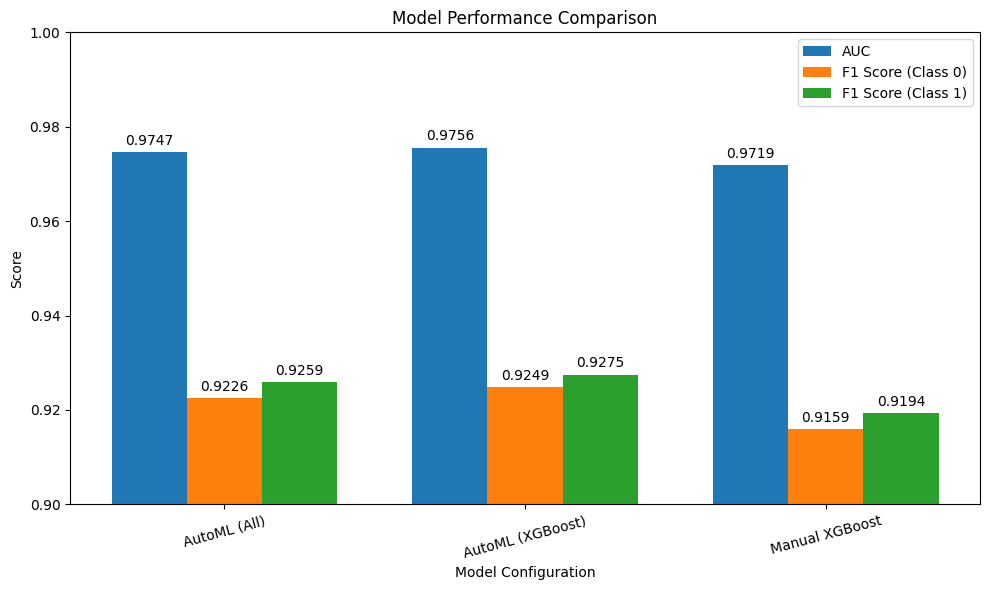

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

# Metrics for the bar chart comparison
models = ['AutoML (All)', 'AutoML (XGBoost)', 'Manual XGBoost']
auc = [0.9747, 0.9756, 0.9719]
f1_class_0 = [0.9226, 0.9249, 0.9159]
f1_class_1 = [0.9259, 0.9275, 0.9194]

# Plotting bar chart for AUC and F1 scores
x = np.arange(len(models))
width = 0.25

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width, auc, width, label='AUC')
bars2 = ax.bar(x, f1_class_0, width, label='F1 Score (Class 0)')
bars3 = ax.bar(x + width, f1_class_1, width, label='F1 Score (Class 1)')

ax.set_xlabel('Model Configuration')
ax.set_ylabel('Score')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=15)
ax.legend()
ax.set_ylim(0.9, 1.0)

# Annotate bars
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.4f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', va='bottom')

plt.tight_layout()
plt.show()



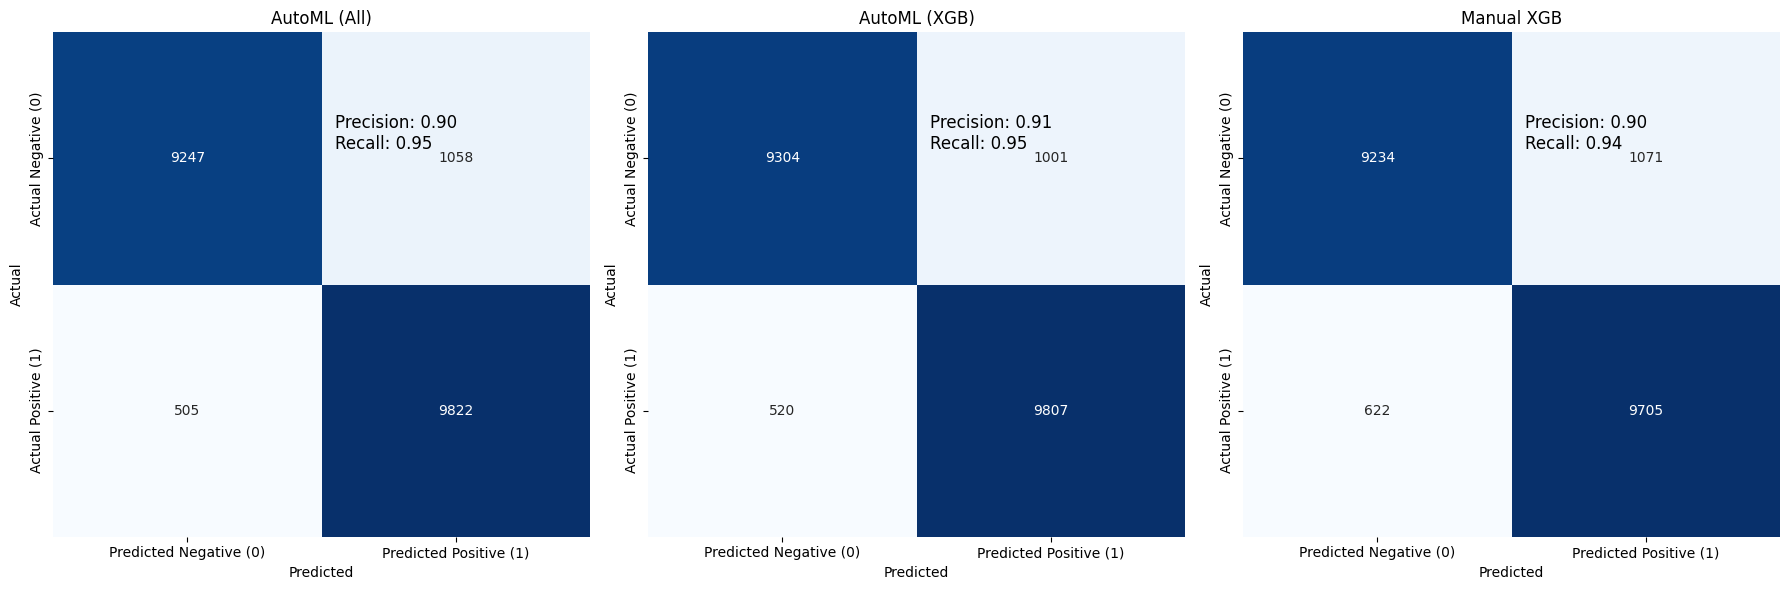

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Confusion matrices for each model
data = {
    "Model": ["AutoML (All)", "AutoML (All)", "AutoML (XGB)", "AutoML (XGB)", "Manual XGB", "Manual XGB"],
    "Actual": ["0", "1", "0", "1", "0", "1"],
    "Predicted 0": [9247, 505, 9304, 520, 9234, 622],
    "Predicted 1": [1058, 9822, 1001, 9807, 1071, 9705]
}

# Convert to DataFrame
df_cm = pd.DataFrame(data)

# Create grouped confusion matrix plot
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
models = ["AutoML (All)", "AutoML (XGB)", "Manual XGB"]

for i, model in enumerate(models):
    model_data = df_cm[df_cm["Model"] == model].set_index("Actual")
    cm = model_data[["Predicted 0", "Predicted 1"]].values

    # Plot confusion matrix
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["Predicted Negative (0)", "Predicted Positive (1)"],
                yticklabels=["Actual Negative (0)", "Actual Positive (1)"], ax=axs[i])
    axs[i].set_title(model)
    axs[i].set_xlabel("Predicted")
    axs[i].set_ylabel("Actual")

    # Add precision, recall as text on top of the plot
    total = cm.sum()
    tn, fp, fn, tp = cm.ravel()

    # Precision and Recall
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0

    # Add these metrics as text on the plot (slightly moved down)
    metrics_text = f"Precision: {precision:.2f}\nRecall: {recall:.2f}"
    axs[i].text(1.05, 0.4, metrics_text, ha='left', va='center', fontsize=12, color='black')

plt.tight_layout()
plt.show()
